In [4]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import random

# Pregunta 1

In [132]:
def calcular_fiedler(matriz_adyacencia):
    A = np.array(matriz_adyacencia)
    D = np.diag(A.sum(axis=1))
    L = D - A

    valores_propios, vectores_propios = np.linalg.eig(L)
    
    indices_ordenados = np.argsort(valores_propios)
    valores_propios_ordenados = valores_propios[indices_ordenados]
    vectores_propios_ordenados = vectores_propios[:, indices_ordenados]
    
    valor_de_fiedler = valores_propios_ordenados[1]
    vector_propio_fiedler = vectores_propios_ordenados[:, 1]
    y = L.view
    
    return valor_de_fiedler, vector_propio_fiedler

In [133]:
Ady = [
    [0, 1, 1, 0, 0, 0, 0],
    [1, 0, 1, 0, 0, 0, 0],
    [1, 1, 0, 1, 0, 0, 0],
    [0, 0, 1, 0, 1, 1, 0],
    [0, 0, 0, 1, 0, 1, 0],
    [0, 0, 0, 1, 1, 0, 1],
    [0, 0, 0, 0, 0, 1, 0]
]

valor_de_fiedler, vector_propio_fiedler = calcular_fiedler(Ady)
print("El valor de Fiedler es:", valor_de_fiedler)
print("El vector propio asociado es:", vector_propio_fiedler)

El valor de Fiedler es: 0.34032095848177074
El vector propio asociado es: [-0.47 -0.47 -0.31  0.11  0.27  0.34  0.51]


In [134]:
np.set_printoptions(precision=2, suppress=True, linewidth=100)
A = np.array(Ady)
D = np.diag(A.sum(axis=1))
L = D - A
print(L)

[[ 2 -1 -1  0  0  0  0]
 [-1  2 -1  0  0  0  0]
 [-1 -1  3 -1  0  0  0]
 [ 0  0 -1  3 -1 -1  0]
 [ 0  0  0 -1  2 -1  0]
 [ 0  0  0 -1 -1  3 -1]
 [ 0  0  0  0  0 -1  1]]


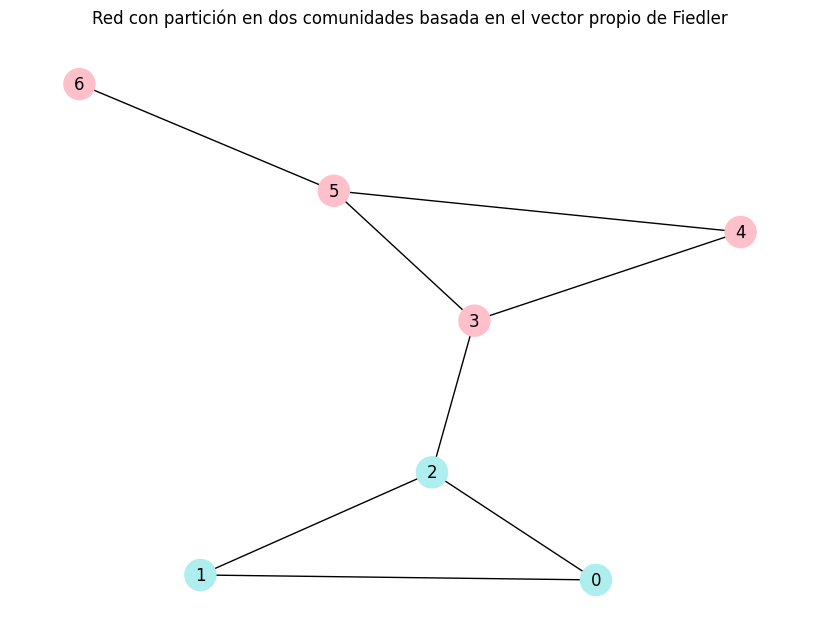

In [135]:
G = nx.from_numpy_array(A)

color_map = []
for value in vector_propio_fiedler:
    if value < 0:
        color_map.append('paleturquoise')
    else:
        color_map.append('pink')


pos = nx.spring_layout(G)  
plt.figure(figsize=(8, 6))

nx.draw(G, pos, node_color=color_map, with_labels=True, node_size=500, cmap=plt.cm.coolwarm)


plt.title('Red con partición en dos comunidades basada en el vector propio de Fiedler')
plt.show()

# Pregunta 6

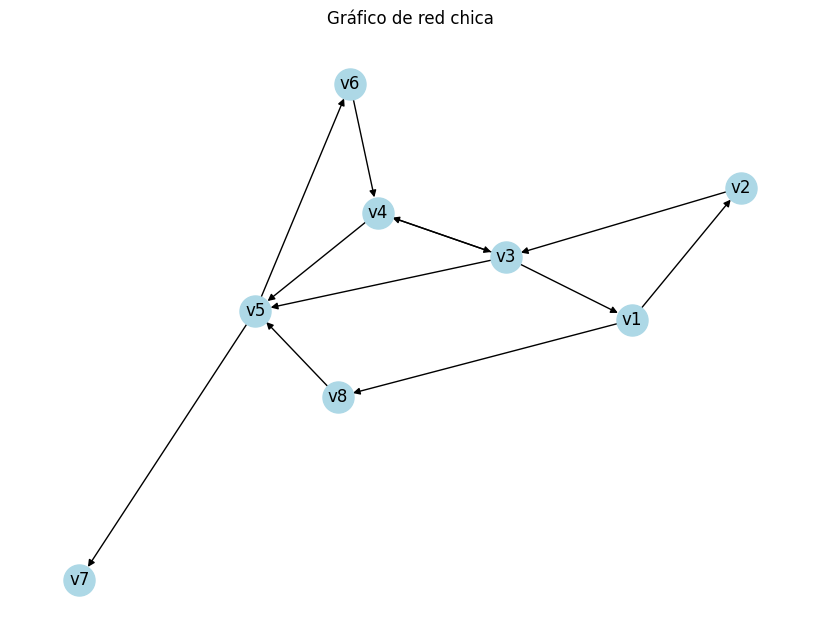

In [114]:
from networkx_gdf import read_gdf

# Builds NetworkX graph object from file.
G6 = read_gdf("Datos/redchica.gdf")

pos = nx.spring_layout(G6)
plt.figure(figsize=(8, 6))

nx.draw(G6, pos, with_labels=True, node_size=500, node_color="lightblue")

plt.title("Gráfico de red chica")
plt.show()

In [92]:
import pandas as pd
in_degree = dict(G6.in_degree())
betweenness = nx.betweenness_centrality(G6)
pagerank = nx.pagerank(G6)
df = pd.DataFrame({
    'Node': list(G.nodes()),
    'In-Degree': [in_degree[node] for node in G6.nodes()],
    'Betweenness': [betweenness[node] for node in G6.nodes()],
    'PageRank': [pagerank[node] for node in G6.nodes()]
})
df

,Node,In-Degree,Betweenness,PageRank
0,v1,1,0.238095,0.077725
1,v2,1,0.047619,0.064579
2,v3,2,0.428571,0.162980
3,v4,2,0.309524,0.180098
4,v5,3,0.357143,0.209159
5,v6,1,0.214286,0.120440
6,v7,1,0.000000,0.120440
7,v8,1,0.071429,0.064579
